**Image Classifier with a Convolution Neural Network (CNN)**

This classifier will classify a X-Ray dataset (https://www.kaggle.com/datasets/andrewmvd/covid19-xray-severity-scoring) using a deep convolutional neural network based on prognostic scoring using the BRIXIA scoring system.

We will use PyTorch (https://pytorch.org/) as our deep learning framework. 

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from imutils import build_montages

# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device("cpu"):
  print('Set the runtime to GPU!')
else:
  print(f"Device: {device}")

Device: cuda


In [2]:
# Add label to save files
save_lab = '-net1'


<!--bibtex
@article{BS-Net2021,
  title = {BS-Net: learning COVID-19 pneumonia severity on a large Chest X-Ray dataset},
  journal = {Medical Image Analysis},
  pages = {102046},
  year = {2021},
  issn = {1361-8415},
  doi = {https://doi.org/10.1016/j.media.2021.102046},
  url = {https://www.sciencedirect.com/science/article/pii/S136184152100092X},
  author = {Alberto Signoroni and Mattia Savardi and Sergio Benini and Nicola Adami and Riccardo Leonardi and Paolo Gibellini and Filippo Vaccher and Marco Ravanelli and Andrea Borghesi and Roberto Maroldi and Davide Farina},
}

@article{borghesi2020covid,
  title={COVID-19 outbreak in Italy: experimental chest X-ray scoring system for quantifying and monitoring disease progression},
  author={Borghesi, Andrea and Maroldi, Roberto},
  journal={La radiologia medica},
  volume={125},
  pages={509-513},
  year={2020},
  publisher={Springer}
}
@article{borghesi_et_al_2020, 
    title={Chest X-ray severity index as a predictor of in-hospital mortality in coronavirus disease 2019: A study of 302 patients from Italy}, 
    volume={96}, 
    DOI={10.1016/j.ijid.2020.05.021}, 
    journal={International Journal of Infectious Diseases}, 
    author={Borghesi, Andrea and Zigliani, Angelo and Golemi, Salvatore and Carapella, Nicola and Maculotti, Patrizia and Farina, Davide and Maroldi, Roberto}, 
    year={2020}, 
    pages={291–293}} 
-->
The dataset (https://www.kaggle.com/datasets/andrewmvd/covid19-xray-severity-scoring) will be loaded from Kaggle. Refer to these papers for extensive discussion of the methods relating to this dataset:
([Signoroni et al., 2021](#cite-BS-Net2021)) and ([Borghesi & Maroldi, 2020](#cite-borghesi2020covid)).

The Global Brixia Score labels will be binarized based on a cutoff value of 8 presented in this paper ([Borghesi et al., 2020](#cite-borghesi_et_al_2020)). A binary classification will be done. 

The segmented x-ray images will be used for ease of classification. 


Number of images in the training set: 4545
Number of images in the test set: 150


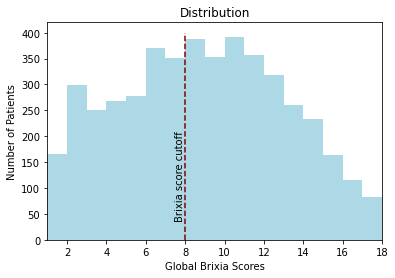

In [3]:
##### -- change to path to files !!!!! ######
path = "path_to_files" 
#############################################

cols = ["Filename","BrixiaScoreGlobal","ConsensusTestset"]
cutoff = 8 # optimal cutoff based on literature (add citation)

# Get list of file paths to images
metadata = pd.read_csv(os.path.join(path,"metadata.csv"),sep=";",usecols=cols)
file_list = metadata.Filename.copy()

for i in range(len(file_list)):
    tmp = str(os.path.splitext(file_list[i])[0])
    file_list[i] = os.path.join(path,"segmented_png",(tmp+".png"))

# Define image labels based on cutoff value
labels = (metadata.BrixiaScoreGlobal >= cutoff)
  # 0 = low Brixia score (< 8)
  # 1 = high Brixia score (>= 8)

# Split into training and test sets
train_files = file_list[(metadata.ConsensusTestset == 0)]
train_labels = labels[metadata.ConsensusTestset == 0]
test_files = file_list[metadata.ConsensusTestset == 1]
test_labels = labels[metadata.ConsensusTestset == 1]
print(f"Number of images in the training set: {len(train_files)}")
print(f"Number of images in the test set: {len(test_files)}")

# Display distribution of Global Brixia Scores
plt.hist(metadata.BrixiaScoreGlobal,18,color='lightblue')
plt.xlabel('Global Brixia Scores')
plt.xlim(1,18)
plt.ylabel('Number of Patients')
plt.title('Distribution')
plt.vlines(cutoff,0,400,colors='maroon',linestyles='dashed')
plt.text(7.5,40,'Brixia score cutoff',rotation='vertical')
plt.savefig(path+'/train_data_distr.png')

In [4]:
### Data Pre-processing ###
transform = transforms.Compose(
    [transforms.ToTensor(), # convert to tensor
     transforms.Normalize((0.5,), (0.5,))]) # normalize

### Define custom dataset ###
class XRayDataset(Dataset):
    def __init__(self,image_paths,image_labels,transform=False):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self,idx):
        image_filepath = self.image_paths.iloc[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        label = (self.image_labels.iloc[idx]).astype(int)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

### Create datasets ###
train_set = XRayDataset(train_files,train_labels,transform)
test_set = XRayDataset(test_files,test_labels,transform)

In [5]:
# Display representative images for each Brixia score
brixscore = list(range(0,19))
brixscore_labels = list(metadata.BrixiaScoreGlobal)
ind = [brixscore_labels.index(x) for x in brixscore]

# Create a montage of images
imgs = []
img = []
for i in brixscore:
    img_path = file_list[i]
    img = cv2.imread(img_path)
    imgs.append(img)
montage = build_montages(imgs,(128,128),(10,2))[0]
cv2.imwrite(path+'/montage.png',montage)

In [6]:
batch_size = 32 # randomly-chosen - ideally, needs a hyperparameter search

# Load the datasets using Pytorch DataLoader
trainloader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=4)
testloader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=4)

image_size = 512 # pixel dimensions of image

/nas/longleaf/home/kathlyne/.conda/envs/comp562/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Creating the model**

In [7]:
# CNN architecture
class simple_cnn(torch.nn.Module):
  def __init__(self,input_channels,n_filters,filt_size,input_size,n_classes):
    super().__init__()

    # inputs
    self.input_channels = input_channels # number of channels in the input image
    self.n_filters = n_filters # list of number of filters in each layer
    self.filt_size = filt_size # list of filter sizes
    self.input_size = input_size  # size of the input image
    self.n_classes = n_classes;

    # avg pooling
    self.pool = torch.nn.AvgPool2d(2,2) 

    # conv layers
    self.conv0 = torch.nn.Conv2d(in_channels = input_channels, out_channels = n_filters[0], kernel_size = filt_size[0], padding = 0, stride = 2)
    self.conv1 = torch.nn.Conv2d(in_channels = n_filters[0], out_channels = n_filters[1], kernel_size = filt_size[1], padding = 0, stride = 2)
    self.conv2 = torch.nn.Conv2d(in_channels = n_filters[1],out_channels = n_filters[2], kernel_size = filt_size[2], padding = 0, stride = 2)

    # linear layer - applies a linear transformation
    self.fc0 = torch.nn.Linear(in_features = 288, out_features = 32)
    self.fc1 = torch.nn.Linear(in_features = 32, out_features = 2) 

  def forward(self,x):
    x = self.conv0(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.fc0(x)
    x = F.relu(x)
    x = self.fc1(x)
    return x

In [8]:
# Model
input_channels = 1 # grayscale image
n_filters = [8,16,32] 
filt_size = [16,16,16]
input_size = image_size
n_classes = 2
model = simple_cnn(input_channels,n_filters,filt_size,input_size,n_classes).to(device)

# Quick check --
sample_tensor = torch.randn((10,1,512,512)).to(device)
out = model(sample_tensor)
print(out.shape)

torch.Size([10, 2])


**Model training**

In [9]:
### Cost function ###
# Cross Entropy Loss
loss_fn = torch.nn.CrossEntropyLoss()

### Optimizer ###
# AdamW Optimizer (with L2 regularization)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [10]:
n_epochs = 100
losses = []
accuracies = []

for epoch in range(n_epochs):  # loop over the dataset multiple times
    early_stop = 0
    running_loss_epoch = 0.0
    running_accuracy_epoch = []
    running_loss = 0.0
    running_accuracy = []
    for idx,data in enumerate(trainloader):
        ### Get data, send it to the GPU
        img,lab = data
        img = img.to(device)
        lab = lab.to(device)

        ### Model calculations
        # zero the gradients out
        optimizer.zero_grad()
        # get the predictions of the model and compute the loss
        out = model(img)
        # print(out.shape,lab.shape)
        loss = loss_fn(out,lab)
        # calculate the gradient and take a step with the model
        loss.backward()
        optimizer.step()
        # add the loss for this batch to the running loss
        running_loss += loss.item()
        running_loss_epoch += loss.item()
        # running accuracy calculation
        running_accuracy.append(((sum(torch.argmax(out,1) == lab)/batch_size)*100).item())
        running_accuracy_epoch.append(((sum(torch.argmax(out,1) == lab)/batch_size)*100).item())
        if (idx+1) % 20 == 0: 
            print(f'[{epoch + 1}, {idx + 1:5d}] loss: {running_loss / 20:.3f}, accuracy: {np.mean(running_accuracy):3.2f}%')
            running_loss = 0.0 # reset this value, else your loss will seem to be going up every time
            running_accuracy = []
    losses.append(running_loss_epoch)
    accuracies.append(np.mean(running_accuracy_epoch))
    if np.mean(losses[-3:]) < 30:
        print('Early stop')
        break

[1,    20] loss: 0.677, accuracy: 57.03%
[1,    40] loss: 0.627, accuracy: 65.31%
[1,    60] loss: 0.610, accuracy: 69.53%
[1,    80] loss: 0.614, accuracy: 67.03%
[1,   100] loss: 0.592, accuracy: 70.31%
[1,   120] loss: 0.627, accuracy: 65.62%
[1,   140] loss: 0.590, accuracy: 69.22%
[2,    20] loss: 0.586, accuracy: 68.59%
[2,    40] loss: 0.618, accuracy: 65.47%
[2,    60] loss: 0.587, accuracy: 69.38%
[2,    80] loss: 0.558, accuracy: 71.41%
[2,   100] loss: 0.591, accuracy: 70.00%
[2,   120] loss: 0.618, accuracy: 65.16%
[2,   140] loss: 0.578, accuracy: 72.66%
[3,    20] loss: 0.605, accuracy: 66.88%
[3,    40] loss: 0.564, accuracy: 70.94%
[3,    60] loss: 0.577, accuracy: 70.47%
[3,    80] loss: 0.574, accuracy: 71.09%
[3,   100] loss: 0.546, accuracy: 72.66%
[3,   120] loss: 0.544, accuracy: 74.22%
[3,   140] loss: 0.551, accuracy: 73.75%
[4,    20] loss: 0.569, accuracy: 70.62%
[4,    40] loss: 0.562, accuracy: 70.62%
[4,    60] loss: 0.568, accuracy: 69.53%
[4,    80] loss:

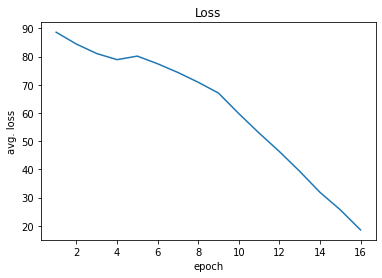

In [11]:
# Plot losses
plt.plot(range(1,np.shape(losses)[0]+1),losses)
plt.xlabel('epoch')
plt.ylabel('avg. loss')
plt.title('Loss')
plt.savefig(path+'/loss'+save_lab+'.png')

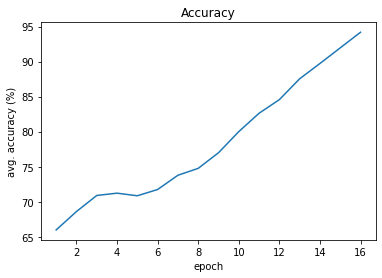

In [12]:
# Plot accuracies
plt.plot(range(1,np.shape(accuracies)[0]+1),accuracies)
plt.xlabel('epoch')
plt.ylabel('avg. accuracy (%)')
plt.title('Accuracy')
plt.savefig(path+'/accuracy'+save_lab+'.png')

In [13]:
# Save the model
PATH = path+'/covid_xray_classifier'+save_lab+'.pth'
torch.save(model.state_dict(), PATH)

**Running the model on the test set**

In [14]:
# # Load model
# model.load_state_dict(torch.load(PATH))

In [15]:
correct = 0
total = 0

lab_pred = []
lab_true = []

with torch.no_grad():
    # iterate over test data
    for data in testloader:
        img, lab = data
        img = img.to(device)
        lab = lab.to(device)
        # calculate outputs by running images through the network
        out = model(img)
        # the class with the highest energy is what we choose as prediction
        pred = torch.argmax(out.data, 1)
        total += lab.size(0)
        correct += (pred == lab).sum().item()

        lab_pred.extend(pred.tolist()) # Save predictions
        lab_true.extend(lab.tolist()) # Save true labels

print(f'Accuracy of the network on the {total} test images: {100 * correct // total}%')

Accuracy of the network on the 150 test images: 75%


**Generate Confusion Matrix**

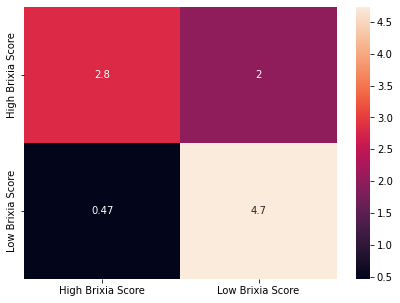

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# Classes
classes = ('High Brixia Score','Low Brixia Score')

# Build confusion matrix
cf_matrix = confusion_matrix(lab_true, lab_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True)
plt.savefig(path+'/confusion_matrix'+save_lab+'.png')